<a href="https://colab.research.google.com/github/dlsyscourse/public_notebooks/blob/main/24_machine_learning_compilation_deployment_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 24: Machine Learning Compiler and Deployment

In this lecture, we will walk you through some example usage of the machine learning compiler Apache TVM. To learn more, checkout https://tvm.apache.org/

The content of this lecture is adapted from TVM's tutorials.



## Install package

To get started, we need to obtain a version of TVM. For quick demo purpose we will use the following command to install a latest version of the TVM unity compiler and related language model dependenchy solution

In [2]:
!pip install --pre  mlc-ai-nightly-cu121 mlc-llm-nightly-cu121 -f https://mlc.ai/wheels

Looking in links: https://mlc.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.5/167.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
   

## Loop-level representation and transformations

Let us start with a vector add example. the follow code snippet allows us to create a vector add code, and store it in a container called IRModule.

In [3]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T
import numpy as np

In [4]:
def lnumpy_add(a, b, c):
    for i in range(128):
        c[i] = a[i] + b[i]

In [5]:
from tvm import te

A = te.placeholder(shape=(128,), dtype="float32", name="A")
B = te.placeholder(shape=(128,), dtype="float32", name="B")
C = te.compute((128,), lambda i: A[i] + B[i], name="C")
func = te.create_prim_func([A, B, C])
func = func.with_attr("global_symbol", "main")
ir_module = IRModule({"main": func})

An IRModule contains a collection of low-level functions, we can use the script function to inspect the functions inside an IRModule.  

In [6]:
ir_module.show()

### Build and run

We can turn the programs in an IRModule to runnable functions by calling a build function.

In [7]:
rt_mod = tvm.build(ir_module, target="llvm")  # The module for CPU backends.
print(type(rt_mod))

<class 'tvm.driver.build_module.OperatorModule'>


After build, mod contains a collection of runnable functions. We can retrieve each function by its name.

In [8]:
func = rt_mod["main"]

In [9]:
func

In [10]:
a = tvm.nd.array(np.arange(128, dtype="float32"))

In [11]:
b = tvm.nd.array(np.ones(128, dtype="float32"))

In [12]:
c = tvm.nd.empty((128,), dtype="float32")

In [13]:
 c

<tvm.nd.NDArray shape=(128,), cpu(0)>
array([          nan,           nan, 0.0000000e+00, 0.0000000e+00,
       1.4012985e-45, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       7.3384490e+21, 3.1205516e-41, 0.0000000e+00, 0.0000000e+00,
       4.4841551e-44, 0.0000000e+00,           nan, 4.2038954e-45,
       1.5694543e-43, 0.0000000e+00, 1.5694543e-43, 0.0000000e+00,
       1.1112200e-31, 3.1198509e-41, 7.3384760e+21, 3.1205516e-41,
       0.0000000e+00, 5.6051939e-45, 1.1479437e-40, 0.0000000e+00,
       7.3039829e+21, 3.1205516e-41, 7.3241500e+21, 3.1205516e-41,
       7.3040279e+21, 3.1205516e-41, 7.3042531e+21, 3.1205516e-41,
       7.3242671e+21, 3.1205516e-41, 8.9683102e-44, 1.4012985e-45,
       1.4012985e-45, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 7.4128689e-43, 0.0000000e+00,
       3.3631163e-43, 0.0000000e+00, 1.7936620e-43, 0.0000000e+00,
       1.1511097e-31, 3.1198509e-41, 7.2055432e+21, 3.1205516e-41,
       8.1226202e+21, 3.

To invoke the function, we can create three NDArrays in the tvm runtime, and then invoke the generated function.

In [14]:
func(a, b, c)


In [15]:
print(a)
print(b)
print(c)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

### Transform the code

The IRModule is the central data structure for program optimization, which can be transformed by a helper class called Schedule. A schedule contains multiple primitive methods to interactively transform the program. Each primitive transforms the program in certain ways to bring additional performance optimizations.

Let us try to transform the module, we can do it by creating a Schedule instance.


In [32]:
sch = tvm.tir.Schedule(ir_module)

In [33]:
sch.mod.show()

In [34]:
blockC = sch.get_block("C")
i, = sch.get_loops(blockC)

In [35]:
i0, i1 = sch.split(i, factors=[None, 8])

In [36]:
sch.mod.show()

In [37]:
sch.reorder(i1, i0)

In [38]:
sch.mod.show()

In [39]:
sch.reorder(i0, i1)

In [40]:
sch.mod.show()

In [41]:
sch.parallel(i0)
sch.vectorize(i1)

In [42]:
sch.mod.show()

## Transforming a matrix multiplication program

In the above example, we showed how to transform an vector add. Now let us try to apply that to a slightly more complicated program(matrix multiplication).


In [43]:
M = 1024
K = 1024
N = 1024

# The default tensor type in tvm
dtype = "float32"

target = "llvm"
dev = tvm.device(target, 0)

# Algorithm
k = te.reduce_axis((0, K), "k")
A = te.placeholder((M, K), name="A")
B = te.placeholder((K, N), name="B")
C = te.compute((M, N), lambda m, n: te.sum(A[m, k] * B[k, n], axis=k), name="C")

# Default schedule
func = te.create_prim_func([A, B, C])
func = func.with_attr("global_symbol", "main")
ir_module = IRModule({"main": func})
ir_module.show()

In [44]:
func = tvm.build(ir_module, target="llvm")  # The module for CPU backends.
a_np = np.random.rand(M, K).astype(dtype)
b_np = np.random.rand(K, N).astype(dtype)
a = tvm.nd.array(a_np, dev)
b = tvm.nd.array(b_np, dev)
c = tvm.nd.array(np.zeros((M, N), dtype=dtype), dev)
func(a, b, c)

evaluator = func.time_evaluator("main", dev, number=3)
print("Baseline time cost %g sec" % evaluator(a, b, c).mean)

Baseline time cost 3.1031 sec


In [45]:
c.numpy() - a_np @b_np

array([[ 9.1552734e-05,  1.5258789e-05,  9.1552734e-05, ...,
         3.0517578e-05,  1.0681152e-04, -6.1035156e-05],
       [ 1.2207031e-04,  1.0681152e-04, -6.1035156e-05, ...,
        -7.6293945e-05,  6.1035156e-05, -3.0517578e-05],
       [ 3.2043457e-04, -3.0517578e-05,  3.0517578e-05, ...,
        -9.1552734e-05,  3.0517578e-05, -7.6293945e-05],
       ...,
       [ 6.1035156e-05,  0.0000000e+00,  3.0517578e-05, ...,
         0.0000000e+00,  1.0681152e-04, -2.7465820e-04],
       [ 1.5258789e-05, -6.1035156e-05, -1.8310547e-04, ...,
        -1.5258789e-04, -2.2888184e-04, -6.1035156e-05],
       [ 9.1552734e-05, -4.5776367e-05,  6.1035156e-05, ...,
         6.1035156e-05, -1.5258789e-05,  3.0517578e-05]], dtype=float32)

In [46]:
ir_module.show()

We can transform the loop access pattern to make it more cache friendly. Let us use the following schedule.

In [47]:
def transform(sch, tile_m, tile_n):
    block_C = sch.get_block("C")
    m, n, k = sch.get_loops(block_C)
    mo, mi = sch.split(m, [None, tile_m])
    no, ni = sch.split(n, [None, tile_n])
    sch.reorder(mo, no, k, mi, ni)
    return sch
sch = tvm.tir.Schedule(ir_module)
sch = transform(sch, 8, 8)
sch.mod.show()

In [48]:
sch = tvm.tir.Schedule(ir_module)
sch = transform(sch, 32, 32)
sch.mod.show()
mod = tvm.build(sch.mod, target="llvm")
new_eval = mod.time_evaluator("main", number=3, dev=tvm.cpu())
print("Transformed time cost %g sec" % new_eval(a, b, c).mean)

Transformed time cost 0.286962 sec


Try to change the value of bn to see what performance you can get. In pratice, we will leverage an automated system to search over a set of possible transfromations to find an optimal one.



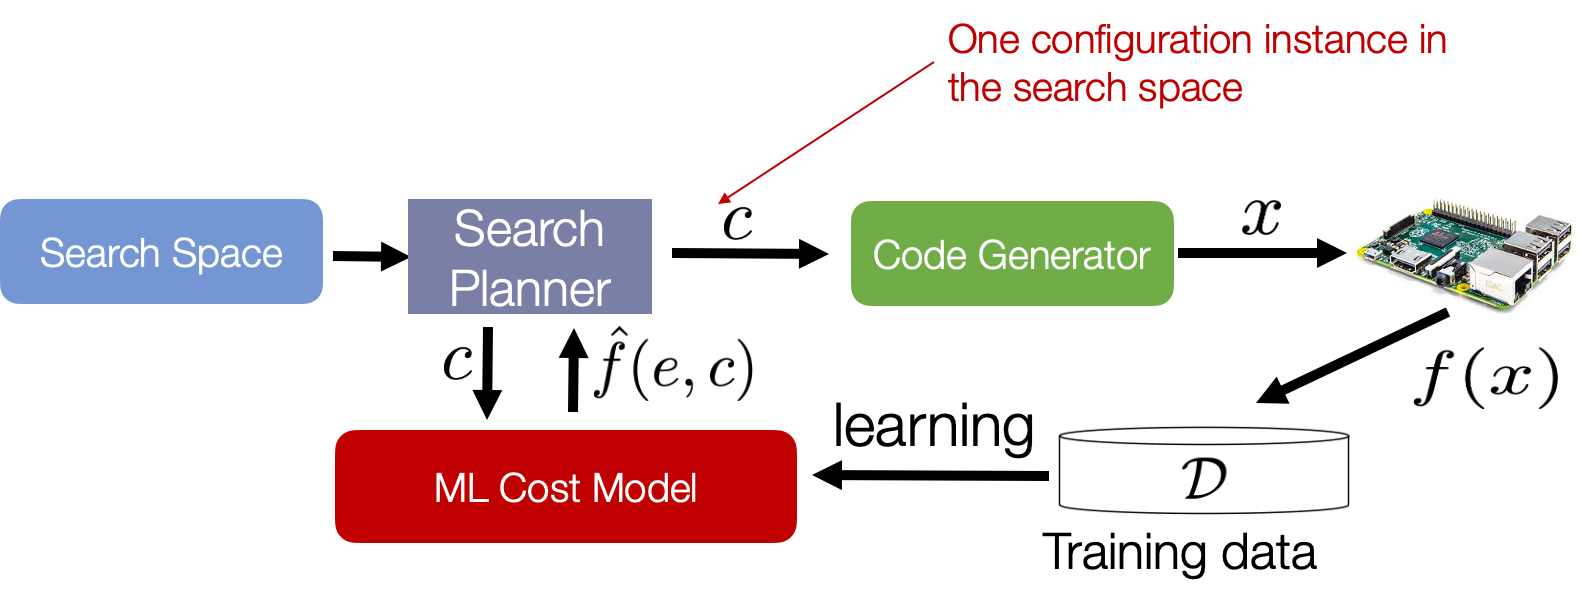

There are other optimizations that can be applied here, such as vectorization, parallelization and data layout optimization. Please checkout

## End to end model deployment

Finally, let us walk through an example flow for an end to end model deployment.



In [49]:
!git lfs install


Git LFS initialized.


In [1]:
from mlc_llm import MLCEngine

# Create engine
model = "HF://mlc-ai/Llama-3-8B-Instruct-q4f16_1-MLC"
engine = MLCEngine(model)


In [2]:
# Run chat completion in OpenAI API.
for response in engine.chat.completions.create(
    messages=[{"role": "user", "content": "Tell me about cmu?"}],
    model=model,
    stream=True,
):
    for choice in response.choices:
        print(choice.delta.content, end="", flush=True)
print("\n")


Carnegie Mellon University (CMU) is a private research university with a rich history and a strong reputation for excellence in various fields. Here are some key facts about CMU:

**Location**: CMU is located in Pittsburgh, Pennsylvania, a city known for its cultural and economic revitalization.

**History**: Founded in 1900 as the Carnegie Technical Schools, CMU was established by Andrew Carnegie, a Scottish-American industrialist and philanthropist. The university has since grown to become one of the top-ranked institutions in the world.

**Academics**: CMU offers a wide range of undergraduate and graduate programs across seven schools:

1. School of Computer Science
2. School of Engineering
3. Tepper School of Business
4. Dietrich College of Humanities and Social Science
5. Mellon College of Science
6. College of Fine Arts
7. School of Public Policy and Management

**Research**: CMU is known for its interdisciplinary research, with a strong focus on artificial intelligence, machine 